# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`

**Note**: it is not necessary to install the `zensols.deeplearn` package to run this notebook.


## What is demoed

This notebook shows how to create an executor directly.  However, an easier more client friendly facade is available and given in the *mnist* notebook.

Also see the the *debug* notebook, which demostrates how to debug a model.

In [1]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [2]:
import logging
from pathlib import Path
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn import TorchConfig
from zensols.deeplearn.result import ModelResultGrapher

# initialze PyTorch and set the random seed so things are predictable
TorchConfig.init()

temp_dir = Path('../target')
if temp_dir.is_dir():
    import shutil
    print(f'removing previous results in {temp_dir}')
    shutil.rmtree(temp_dir)

# configure logging
logging.basicConfig(format='%(asctime)-15s %(name)s [%(levelname)s]: %(message)s',
                    level=logging.WARNING)
for name in ['zensols.deeplearn.result',
             'zensols.deeplearn.model.facade',
             'zensols.deeplearn.batch.stash']:
    logging.getLogger(name).setLevel(logging.INFO)

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config)

removing previous results in ../target


## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
executor = factory('executor')
executor.write()

2021-05-08 11:04:32,891 zensols.deeplearn.batch.stash [INFO]: batch_dataset_stash: creating keys with (<class 'zensols.dataframe.stash.DefaultDataframeStash'>) using batch size of 20
2021-05-08 11:04:32,894 zensols.deeplearn.batch.stash [INFO]: keys for split dev: 12
2021-05-08 11:04:32,894 zensols.deeplearn.batch.stash [INFO]: keys for split test: 25
2021-05-08 11:04:32,895 zensols.deeplearn.batch.stash [INFO]: keys for split train: 113
2021-05-08 11:04:32,896 zensols.deeplearn.batch.stash [INFO]: created 9 each set limited with 9223372036854775807 with batch_limit=9223372036854775807


model: Iris
feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
            dev: 1 (11.1%)
            test: 2 (22.2%)
            train: 6 (66.7%)
            total: 9
    total this instance: 9
    keys consistent: True
    delegate:
        name: batch_dataset_stash
        chunk_size: 0
        workers: 8
        batch_size: 20
        data_point_id_sets_path: ../target/iris/batch/batch-point-keys.dat
        batch_limit: 9223372036854775807
        delegate_attr: True
        _has_data: True
        is_child: False
        priming: False


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation is `_create_model`, and not meant to be called by the client.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [4]:
print(executor._create_model())

IrisNetwork(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): DeepLinear(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin_layers): Sequential(
      (0): Linear(in_features=4, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=1, bias=True)
      (2): Linear(in_features=1, out_features=3, bias=True)
    )
  )
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

2021-05-08 11:04:36,593 zensols.deeplearn.batch.stash [INFO]: loaded batch 3 (train) in 0s
2021-05-08 11:04:36,597 zensols.deeplearn.batch.stash [INFO]: loaded batch 4 (train) in 0s
2021-05-08 11:04:36,601 zensols.deeplearn.batch.stash [INFO]: loaded batch 5 (train) in 0s
2021-05-08 11:04:36,605 zensols.deeplearn.batch.stash [INFO]: loaded batch 6 (train) in 0s
2021-05-08 11:04:36,608 zensols.deeplearn.batch.stash [INFO]: loaded batch 7 (train) in 0s
2021-05-08 11:04:36,611 zensols.deeplearn.batch.stash [INFO]: loaded batch 8 (train) in 0s
2021-05-08 11:04:38,682 zensols.deeplearn.batch.stash [INFO]: loaded batch 0 (dev) in 0s
tr:8.434|va min:3.964|va:4.361 /\: 100%|███████| 15/15 [00:00<00:00, 65.71it/s]2021-05-08 11:04:38,924 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2021-05-08 11:04:38,926 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s
tr:8.434|va min:3.964|va:4.361 /\: 100%|███████| 15/15 [00:00<00:00, 58.37it/s]


Name: Iris: 1
Run index: 2
Learning rate: 0.1
    train:
        started: 05/08/2021 11:04:38:687385
        ended: 05/08/2021 11:04:38:906918
        batches: 6
        ave data points per batch/total: 18.8/113
        converged/epochs: 10/15
        ave/min loss: 7.48554/3.25940
        accuracy: 0.637 (72/113)
        micro: F1: 0.637, precision: 0.637, recall: 0.637
        macro: F1: 0.544, precision: 0.658, recall: 0.647
        weighted: F1: 0.538, precision: 0.661, recall: 0.637
    validation:
        batches: 1
        ave data points per batch/total: 12.0/12
        converged/epochs: 9/15
        ave/min loss: 3.96448/3.96448
        accuracy: 0.750 (9/12)
        micro: F1: 0.750, precision: 0.750, recall: 0.750
        macro: F1: 0.608, precision: 0.567, recall: 0.667
        weighted: F1: 0.647, precision: 0.575, recall: 0.750
    test:
        started: 05/08/2021 11:04:38:928595
        ended: 05/08/2021 11:04:38:930110
        batches: 2
        ave data points per batc

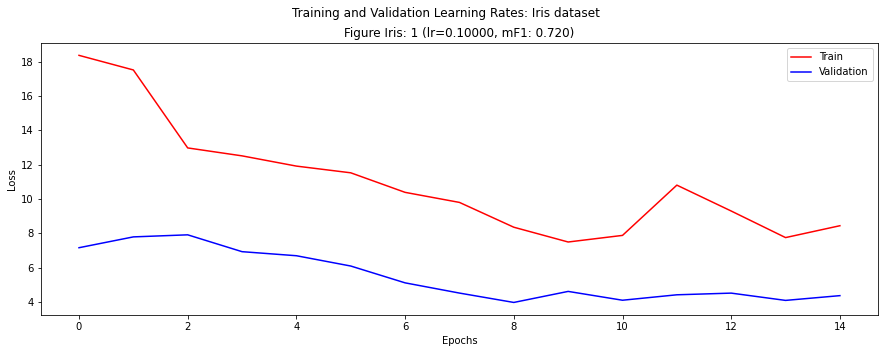

In [5]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot([res])

## Create the model facade

An easier wasy to use the executor is with a *facade*.  A `ModelFacade` provides easy to use client entry points to the model executor, which trains, validates, tests, saves and loads the model.  Create the facade with a factory, which in turn creates the executor.  The statistics on the data set that is configured on the executor is, by default, printed to standard out.  You can set the `writer` property to `None` on the facade to disable this.

In [6]:
from dataclasses import dataclass
from zensols.deeplearn.model import ModelFacade

@dataclass
class IrisModelFacade(ModelFacade):
    def _configure_debug_logging(self):
        super()._configure_debug_logging()
        logging.getLogger('iris.model').setLevel(logging.DEBUG)
        
# deallocate the previous executor
executor.deallocate()
# create the facade
facade = IrisModelFacade(config)

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We can do that by adjusting the hyperparameters directly on the facade.  In fact, the purpose of the facade is to make changes easily such as this.

Notice that the facade prints the output with a correctly configured scroll bar by default.  Output can be disabled by setting the `writer` attribute/initializer parameter to `None`.  The progress bar and columns are set with the `progress_bar` and `progress_bar_col` attributes.

In [7]:
# set the number of epochs and learning rate, which are both model parameters
facade.epochs = 20
facade.learning_rate = .01
# train and test the model
facade.train()
facade.test()
# display the results in this cell
facade.write_result()

2021-05-08 11:04:39,228 zensols.deeplearn.model.facade [INFO]: creating new executor
2021-05-08 11:04:39,245 zensols.deeplearn.model.facade [INFO]: training...
2021-05-08 11:04:39,250 zensols.deeplearn.batch.stash [INFO]: loaded batch 3 (train) in 0s
2021-05-08 11:04:39,254 zensols.deeplearn.batch.stash [INFO]: loaded batch 4 (train) in 0s
2021-05-08 11:04:39,258 zensols.deeplearn.batch.stash [INFO]: loaded batch 5 (train) in 0s
2021-05-08 11:04:39,262 zensols.deeplearn.batch.stash [INFO]: loaded batch 6 (train) in 0s
2021-05-08 11:04:39,266 zensols.deeplearn.batch.stash [INFO]: loaded batch 7 (train) in 0s
2021-05-08 11:04:39,268 zensols.deeplearn.batch.stash [INFO]: loaded batch 8 (train) in 0s
2021-05-08 11:04:39,273 zensols.deeplearn.batch.stash [INFO]: loaded batch 0 (dev) in 0s
tr:12.348|va min:8.213|va:8.160 \/:  45%|███▏   | 9/20 [00:00<00:00, 62.32it/s]

model: Iris
feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
            dev: 1 (11.1%)
            test: 2 (22.2%)
            train: 6 (66.7%)
            total: 9
    total this instance: 9
    keys consistent: True
    delegate:
        name: batch_dataset_stash
        chunk_size: 0
        workers: 8
        batch_size: 20
        data_point_id_sets_path: ../target/iris/batch/batch-point-keys.dat
        batch_limit: 9223372036854775807
        delegate_attr: True
        _has_data: True
        is_child: False
        priming: False


tr:11.790|va min:7.829|va:7.780 \/:  95%|█████▋| 19/20 [00:00<00:00, 56.66it/s]2021-05-08 11:04:39,657 zensols.deeplearn.model.facade [INFO]: trained in 0s
tr:11.790|va min:7.829|va:7.780 \/: 100%|██████| 20/20 [00:00<00:00, 52.05it/s]
2021-05-08 11:04:39,673 zensols.deeplearn.model.facade [INFO]: testing...
2021-05-08 11:04:39,676 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2021-05-08 11:04:39,678 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s
2021-05-08 11:04:39,682 zensols.deeplearn.model.facade [INFO]: trained in 0s
2021-05-08 11:04:39,718 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.01
    train:
        started: 05/08/2021 11:04:39:277683
        ended: 05/08/2021 11:04:39:640240
        batches: 6
        ave data points per batch/total: 18.8/113
        converged/epochs: 20/20
        ave/min loss: 11.78964/9.16269
        accuracy: 0.451 (51/113)
        micro: F1: 0.451, precision: 0.451, recall: 0.451
        macro: F1: 0.379, precision: 0.395, recall: 0.443
        weighted: F1: 0.385, precision: 0.398, recall: 0.451
    validation:
        batches: 1
        ave data points per batch/total: 12.0/12
        converged/epochs: 20/20
        ave/min loss: 7.77986/7.77986
        accuracy: 0.333 (4/12)
        micro: F1: 0.333, precision: 0.333, recall: 0.333
        macro: F1: 0.378, precision: 0.296, recall: 0.556
        weighted: F1: 0.217, precision: 0.167, recall: 0.333
    test:
        started: 05/08/2021 11:04:39:680723
        ended: 05/08/2021 11:04:39:681944
        batches: 2
        ave data points per b

## Network parameters

While we're at it, let's also adjust the drop out, which is a network settings, to see if we can get better results.  Also note that the model converged pretty late indicating we aren't over training, so add more epochs.

2021-05-08 11:04:39,762 zensols.deeplearn.model.facade [INFO]: training...
tr:6.175|va min:3.078|va:3.217 /\: 100%|███▉| 999/1000 [00:18<00:00, 87.47it/s]2021-05-08 11:04:59,074 zensols.deeplearn.model.facade [INFO]: trained in 19s
tr:6.175|va min:3.078|va:3.217 /\: 100%|███| 1000/1000 [00:19<00:00, 51.77it/s]
2021-05-08 11:04:59,402 zensols.deeplearn.model.facade [INFO]: testing...
2021-05-08 11:04:59,405 zensols.deeplearn.model.facade [INFO]: trained in 0s
2021-05-08 11:04:59,406 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 05/08/2021 11:04:39:767219
        ended: 05/08/2021 11:04:58:433818
        batches: 6
        ave data points per batch/total: 18.8/113
        converged/epochs: 934/1000
        ave/min loss: 5.61284/2.86892
        accuracy: 0.885 (100/113)
        micro: F1: 0.885, precision: 0.885, recall: 0.885
        macro: F1: 0.884, precision: 0.885, recall: 0.888
        weighted: F1: 0.883, precision: 0.885, recall: 0.885
    validation:
        batches: 1
        ave data points per batch/total: 12.0/12
        converged/epochs: 903/1000
        ave/min loss: 3.07784/3.07784
        accuracy: 1.000 (12/12)
        micro: F1: 1.000, precision: 1.000, recall: 1.000
        macro: F1: 1.000, precision: 1.000, recall: 1.000
        weighted: F1: 1.000, precision: 1.000, recall: 1.000
    test:
        started: 05/08/2021 11:04:59:404510
        ended: 05/08/2021 11:04:59:405734
        batches: 2
        ave data poin

2021-05-08 11:05:00,030 zensols.deeplearn.result.manager [INFO]: copying model ../target/iris/model -> ../target/iris/results/iris-1.model
2021-05-08 11:05:00,033 zensols.deeplearn.result.manager [INFO]: saving text results to ../target/iris/results/iris-1.txt
2021-05-08 11:05:00,428 zensols.deeplearn.result.manager [INFO]: saving json results to ../target/iris/results/iris-1.json
2021-05-08 11:05:00,760 zensols.deeplearn.result.plot [INFO]: saving results graph to ../target/iris/results/iris-1.png


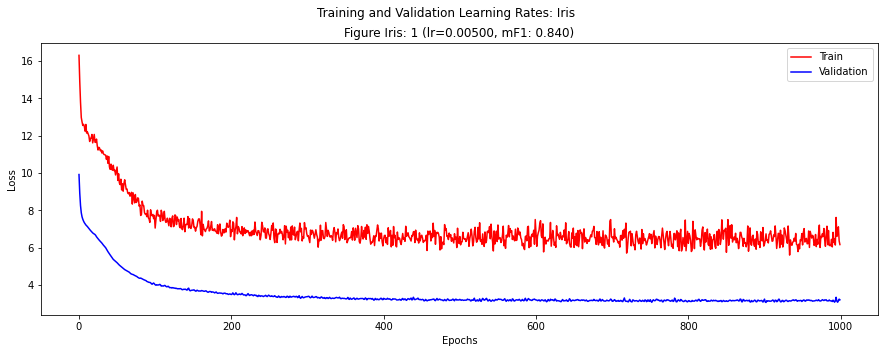

In [8]:
# turn off output so we can get just the final results later with `write_result`
facade.writer = None
# set network parameter `dropout` and model settings to achieve better performance
facade.dropout = 0.1
# set lower learning rate and compensate with epochs in case learning is slower
facade.epochs = 1000
facade.learning_rate = .005
# train and test again
facade.train()
facade.test()
# display the results in this cell
facade.write_result()
# plot results
facade.plot_result()
# now since we like our results, save them to disk
facade.persist_result()

## Predictions

The executor contains the results from the last run, in additional to saving it.  In our case, we have the same instance of the model we just tested, which contains not only the performance metrics, but the predictions themselves.  Use `get_predictions` to get a Pandas `pd.DataFrame` for the results.

In [9]:
from iris.model import IrisDataPoint

# optionally, we can transform the data point instance used, otherwise it defaults to `str`
def map_data_point(dp: IrisDataPoint):
    """Map the data point's Pandas row information (pd.Series) to key/value string.
    
    :param dp: the data point created by the ``iris_dataset_stash`` as defined in the configuration
    
    """
    s = ', '.join(map(lambda x: f'{x[0]}={x[1]}', dp.row.iteritems()))
    return dp.row['sepal_length'], dp.row['sepal_width'], dp.row['petal_length'], dp.row['petal_width']
facade.get_predictions(column_names=['sepal length', 'sepal width', 'petal length', 'petal width'], transform=map_data_point)

2021-05-08 11:05:01,047 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2021-05-08 11:05:01,063 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s


,id,label,pred,correct,sepal length,sepal width,petal length,petal width
0,17,setosa,setosa,True,5.1,3.5,1.4,0.3
1,30,setosa,setosa,True,4.8,3.1,1.6,0.2
2,31,setosa,setosa,True,5.4,3.4,1.5,0.4
3,33,setosa,setosa,True,5.5,4.2,1.4,0.2
4,41,setosa,setosa,True,4.5,2.3,1.3,0.3
5,43,setosa,setosa,True,5.0,3.5,1.6,0.6
6,45,setosa,setosa,True,4.8,3.0,1.4,0.3
7,46,setosa,setosa,True,5.1,3.8,1.6,0.2
8,48,setosa,setosa,True,5.3,3.7,1.5,0.2
9,49,setosa,setosa,True,5.0,3.3,1.4,0.2


In [10]:
from zensols.persist import dealloc
from zensols.deeplearn.model import ModelFacade
from pathlib import Path

# deallocate the previous facade
facade.deallocate()
path = Path('../target/iris/results/iris-1.model')
# create a new facade wrapped in a deallocation block
# (it will be deallocated even in an error generated in the block)
with dealloc(ModelFacade.load_from_path(path)) as facade:
    facade.write_result()
# note that no test results are given since this model was saved during
# training after achieving the lowest validation loss

2021-05-08 11:05:01,119 zensols.deeplearn.model.facade [INFO]: loading from facade from ../target/iris/results/iris-1.model
2021-05-08 11:05:01,808 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 05/08/2021 11:04:39:767219
        ended: 05/08/2021 11:04:58:433818
        batches: 6
        ave data points per batch/total: 18.8/113
        converged/epochs: 934/1000
        ave/min loss: 5.61284/2.86892
        accuracy: 0.885 (100/113)
        micro: F1: 0.885, precision: 0.885, recall: 0.885
        macro: F1: 0.884, precision: 0.885, recall: 0.888
        weighted: F1: 0.883, precision: 0.885, recall: 0.885
    validation:
        batches: 1
        ave data points per batch/total: 12.0/12
        converged/epochs: 903/1000
        ave/min loss: 3.07784/3.07784
        accuracy: 1.000 (12/12)
        micro: F1: 1.000, precision: 1.000, recall: 1.000
        macro: F1: 1.000, precision: 1.000, recall: 1.000
        weighted: F1: 1.000, precision: 1.000, recall: 1.000
    test:
        no results


In [11]:
# we can also revive the model as a facade to test, then we'll get the test results
with dealloc(ModelFacade.load_from_path(path)) as facade:
    facade.writer = None
    facade.test()
    facade.write_result(include_converged=True)

2021-05-08 11:05:01,848 zensols.deeplearn.model.facade [INFO]: loading from facade from ../target/iris/results/iris-1.model
2021-05-08 11:05:02,914 zensols.deeplearn.model.facade [INFO]: testing...
2021-05-08 11:05:02,921 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2021-05-08 11:05:02,923 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s
2021-05-08 11:05:02,926 zensols.deeplearn.model.facade [INFO]: trained in 0s
2021-05-08 11:05:02,927 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 05/08/2021 11:04:39:767219
        ended: 05/08/2021 11:04:58:433818
        batches: 6
        ave data points per batch/total: 18.8/113
        converged/epochs: 934/1000
        average over epoch:
            ave/min loss: 1.16728/2.86892
            accuracy: 0.761 (86020/113000)
            micro: F1: 0.761, precision: 0.761, recall: 0.761
            macro: F1: 0.753, precision: 0.766, recall: 0.765
            weighted: F1: 0.752, precision: 0.768, recall: 0.761
            epoch details:
                index: 0
                batch IDs: 3,4,5,6,7,8
                data point count per batch: 20,20,20,20,20,13
        converged epoch:
            ave/min loss: 5.61284/2.86892
            accuracy: 0.885 (100/113)
            micro: F1: 0.885, precision: 0.885, recall: 0.885
            macro: F1: 0.884, precision: 0.885, recall: 0.888
            weighted: F1: 0.883, precision: 0.885, recall: 0.885
  